In [ ]:
!nvidia-smi

In [2]:
#config consts
DATASET =     {'train':'train.tar.gz',
               'test':'test.tar.gz',}

METADATA=     {'meta':'meta64.csv',
               'meta_x':'meta_extended.csv',
               'train_x':'train_extended.csv',
               'test_x':'test_extended.csv',
               'data_x':'data_extended.csv',
               'meta_with_fold':'meta64_with_fold_and_mgmt.csv',
               'train':'train_labels.csv',
               'train_with_fold':'train_labels_with_fold.csv',
               'sample_sub':'sample_submission.csv',}

CFGMODEL_DIR_DICT = {'B0_64':'effb0-64/',
                     'B0_64x8': 'effb0-64x8/',
                     'B0_64x8_CHAIN':'effb0-64x8-chain/'}

INPUT_DIR ='/content/drive/My\ Drive/kaggle/brain-tumor/input/'

OUTPUT_DIR = {'BSL':'/content/drive/My\ Drive/kaggle/brain-tumor/output/',
              'NORM':'/content/drive/My Drive/kaggle/brain-tumor/output/'}

IMPORT_DIR = '/content/drive/My Drive/kaggle/brain-tumor/nbs/py/'

HENGCK_IM_DIR=IMPORT_DIR+'hcode/'

WORK_DIR='/content/'

DATASET_DIR_DICT = {'64': INPUT_DIR+'64/',}

EXPERIMENT='SZ64_B0_TEST_64x8_CHAIN_NOAUG'
EXPERIMENT_DIR = OUTPUT_DIR['BSL'] + EXPERIMENT+'/'
CFGMODEL_DIR = CFGMODEL_DIR_DICT['B0_64x8_CHAIN']
MRI_TYPES = ['FLAIR','T1w','T1wCE','T2w']

LR_FACTOR=0.1
MAX_LR_PLATEAU=20
PROBS=[0.0,0.0] #mixup, cutmix 
DATASET_DIR = DATASET_DIR_DICT['64']
METADATA_DIR = INPUT_DIR+'metadata/'
FOLDS_SET=[0]
INITIAL_CHECKPOINTS=[None,None,None,None,None]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install madgrad
!pip install timm

import sys
sys.path.append(HENGCK_IM_DIR)
sys.path.append(HENGCK_IM_DIR+CFGMODEL_DIR)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from common import *


# from lib.net.lookahead import *
# from lib.net.radam import *
from madgrad import MADGRAD

from model import *
from dataset import *

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score


def copy_dataset(ds_dict, ds_dir, work_dir):
  for record in ds_dict:
    print('copy', ds_dir+ds_dict[record], ' to', work_dir)
    !cp {ds_dir+ds_dict[record]} {work_dir}
    print('mkdir',work_dir+record)
    !mkdir {work_dir+record}
    print ('tar -xzf',work_dir+ds_dict[record],'-C',work_dir+record)
    !tar -xzf  {work_dir+ds_dict[record]} -C {work_dir+record}
    print ('rm ',work_dir+ds_dict[record])
    !rm {work_dir+ds_dict[record]}
def copy_metadata(md_dict,md_dir,work_dir):
  for record in md_dict:
    print('copy ', md_dir+md_dict[record],' to ',work_dir)
    !cp {md_dir+md_dict[record]} {work_dir}
copy_dataset(DATASET,DATASET_DIR, WORK_DIR)
copy_metadata(METADATA,METADATA_DIR,WORK_DIR)
!ls /content/
!mkdir {EXPERIMENT_DIR}

     |████████████████████████████████| 376 kB 13.3 MB/s 
copy /content/drive/My\ Drive/kaggle/brain-tumor/input/64/train.tar.gz  to /content/
mkdir /content/train
tar -xzf /content/train.tar.gz -C /content/train
rm  /content/train.tar.gz
copy /content/drive/My\ Drive/kaggle/brain-tumor/input/64/test.tar.gz  to /content/
mkdir /content/test
tar -xzf /content/test.tar.gz -C /content/test
rm  /content/test.tar.gz
copy  /content/drive/My\ Drive/kaggle/brain-tumor/input/metadata/meta64.csv  to  /content/
copy  /content/drive/My\ Drive/kaggle/brain-tumor/input/metadata/meta_extended.csv  to  /content/
copy  /content/drive/My\ Drive/kaggle/brain-tumor/input/metadata/train_extended.csv  to  /content/
copy  /content/drive/My\ Drive/kaggle/brain-tumor/input/metadata/test_extended.csv  to  /content/
copy  /content/drive/My\ Drive/kaggle/brain-tumor/input/metadata/data_extended.csv  to  /content/
copy  /content/drive/My\ Drive/kaggle/brain-tumor/input/metadata/meta64_with_fold_and_mgmt.csv  to  /

In [5]:
df_train = pd.read_csv('/content/train_extended.csv')
df_data = pd.read_csv('/content/data_extended.csv')
df_test = pd.read_csv('/content/test_extended.csv')
df_meta_ext = pd.read_csv('/content/meta_extended.csv')

In [ ]:
#model.py
from common import *
from timm.models.efficientnet import *

class Net(torch.nn.Module):
    def __init__(self, verbouse=False):
        super(Net, self).__init__()

        e = efficientnet_b0(pretrained=True, drop_rate=0.2, drop_path_rate=0.2)
        self.verbouse=verbouse
        self.b0 = torch.nn.Sequential(
            e.conv_stem,
            e.bn1,
            e.act1,
        )
        self.b1 = e.blocks[0]
        self.b2 = e.blocks[1]
        self.b3 = e.blocks[2]
        self.b4 = e.blocks[3]
        self.b5 = e.blocks[4]
        self.b6 = e.blocks[5]
        self.b7 = e.blocks[6]
        self.b8 = torch.nn.Sequential(
            e.conv_head,
            e.bn2,
            e.act2,
        )

        self.logit = torch.nn.Linear(1280,1)
       
    # @torch.cuda.amp.autocast()
    def forward(self, image):
        batch_size = len(image)
        x = 2*image-1   
        #if (self.verbouse): print(f'i {x.size()}') 

        x = self.b0(x) 
        #if (self.verbouse): print(f's {x.size()}')
        x = self.b1(x) 
        #if (self.verbouse): print(f'0 {x.size()}')
        x = self.b2(x) 
        #if (self.verbouse): print(f'1 {x.size()}')
        x = self.b3(x)
        #if (self.verbouse): print(f'2 {x.size()}')
        x = self.b4(x) 
        #if (self.verbouse): print(f'3 {x.size()}')
        x = self.b5(x) 
        #if (self.verbouse): print(f'4 {x.size()}')
        x = self.b6(x) 
        #if (self.verbouse): print(f'5 {x.size()}')
        x = self.b7(x) 
        #if (self.verbouse): print(f'6 {x.size()}')
        x = self.b8(x) 
        #if (self.verbouse): print(f'f {x.size()}')
        x = torch.nn.functional.adaptive_avg_pool2d(x,1).reshape(batch_size,-1) 
        #if (self.verbouse): print(f'a {x.size()}')
        x = torch.nn.functional.dropout(x, 0.5, training=self.training)
        #if (self.verbouse): print(f'd {x.size()}')
        logit = self.logit(x)
        return logit

def run_check_net():
    batch_size = 2
    C, H, W = 3, 64, 64
    image = torch.randn(batch_size, C, H, W).cuda()
    net = Net().cuda()
    logit = net(image)

    print('image: ',image.shape)
    print('logit: ',logit.shape)

In [ ]:
#configure.py
image_size=64

In [ ]:
#configure.py 64x8
image_size=512

In [ ]:
#dataset.py

from common import *
from configure import *


from augmentation import *

data_dir='/content'

def make_fold(mode='train-0'):
    
    if 'train' in mode:
        df = pd.read_csv(data_dir+'/train_extended.csv')
        fold = int(mode[-1])
        df.id_dir = df.id_dir.apply(lambda x: str(x).zfill(5))
        df_train = df[df.fold != fold].reset_index(drop=True)
        df_valid = df[df.fold == fold].reset_index(drop=True)
        return df_train, df_valid

    if 'test' in mode:
        df_valid = pd.read_csv(data_dir+'/test_extended.csv')
        df_valid.id_dir = df_valid.id_dir.apply(lambda x: str(x).zfill(5))
        return df_valid

def null_augment(r):
    image = r['image']
    return r


class BTDataset(Dataset):
    def __init__(self, df,df_meta_ext,mri_type='FLAIR', augment=null_augment):
        super().__init__()
        self.df = df
        self.df_meta_ext = df_meta_ext
        self.mri_type = mri_type
        self.augment = augment
        self.length = len(df)

    def __str__(self):
        string  = ''
        string += '\tlen = %d\n'%len(self)
        string += '\tdf  = %s\n'%str(self.df.shape)

        return string


    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]

        df_imgs = self.df_meta_ext[(self.df_meta_ext['BraTS21ID']==d.BraTS21ID) & (self.df_meta_ext['mri_id']==self.mri_type)].reset_index()
        #print(f'ds {d[self.mri_type]-1} {d.BraTS21ID} {self.mri_type}')
        dm = df_imgs.iloc[random.randint(0, d[self.mri_type]-1)]
        image_file = data_dir + '/%s/%s/%s/%s.jpg' % (d.set, d.id_dir,self.mri_type,dm.image_id)
        image = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
        mgmt = d.MGMT_value

        r = {
            'index' : index,
            'd' : d,
            'image' : image,
            'mgmt' : mgmt,
        }
        if self.augment is not None: r = self.augment(r)
        return r


def null_collate(batch):
    collate = defaultdict(list)

    for r in batch:
        for k, v in r.items():
            collate[k].append(v)

    # ---
    batch_size = len(batch)
    mgmt = np.ascontiguousarray(np.stack(collate['mgmt'])).astype(np.float32)
    collate['mgmt'] = torch.from_numpy(mgmt)

    image = np.stack(collate['image'])
    image = image.reshape(batch_size, 1, image_size,image_size).repeat(3,1)
    image = np.ascontiguousarray(image)
    image = image.astype(np.float32) / 255
    collate['image'] = torch.from_numpy(image)

    return collate

def draw_batch(imbatch):
  bs = imbatch.shape[0]
  fig, axs = plt.subplots(1, bs, figsize=(64, 64))
  for i in range(bs):
    axs[i].imshow(imbatch[i,0,:,:],cmap='gray')
  plt.show()

#===============================================================

def run_check_dataset():
    df_train, df_valid = make_fold(mode='train-1')
    #df_valid = make_fold(mode='test')

    dataset = BTDataset(df_valid,df_meta_ext) #null_augment
    print(dataset)

    for i in range(5):
        i = np.random.choice(len(dataset))
        r = dataset[i]

        print('index ' , i)
        print(r['d'])
        print(r['mgmt'])
        print('')
        #image_show('image', r['image'], resize=1)
        #cv2.waitKey(0)

    loader = DataLoader(
        dataset,
        sampler = RandomSampler(dataset),
        batch_size  = 8,
        drop_last   = True,
        num_workers = 0,
        pin_memory  = True,
        collate_fn  = null_collate,
    )
    for t,batch in enumerate(loader):
        if t>30: break

        print(t, '-----------')
        print('index : ', batch['index'])
        print('image : ')
        print('\t', batch['image'].shape, batch['image'].is_contiguous())
        print('mgmt : ')
        print('\t', batch['mgmt'])
        print('\t', batch['mgmt'].shape, batch['mgmt'].is_contiguous())
        print('')

        draw_batch(batch['image'])

     

def run_check_augment():
    def augment(r):
        image = r['image']
        for fn in np.random.choice([
            lambda image : do_random_scale(image, mag=0.20),
            lambda image : do_random_stretch_y(image, mag=0.20),
            lambda image : do_random_stretch_x(image, mag=0.20),
            lambda image : do_random_shift(image, mag=int(0.20*image_size)),
            lambda image : (image)],1):
          image= fn(image)

        for fn in np.random.choice([
            lambda image : do_random_rotate(image, mag=15),
            lambda image : do_random_hflip(image),
            lambda image : (image)],1):
          image= fn(image)

        # ------------------------
        for fn in np.random.choice([
            lambda image : do_random_intensity_shift_contast(image, mag=[0.5,0.5]),
            lambda image : do_random_noise(image, mag=0.05),
            lambda image : do_random_guassian_blur(image),
            lambda image : do_random_blurout(image, size=0.25, num_cut=2),
            lambda image : do_random_clahe(image),
            lambda image : do_histogram_norm(image),
            lambda image : image,],1):
          image = fn(image)

        r['image']=image
        return r

    #---
    df_train, df_valid = make_fold('train-1')
    dataset = BTDataset(df_train,df_meta_ext,augment=augment)
    print(dataset)

    loader = DataLoader(
        dataset,
        sampler = RandomSampler(dataset),
        batch_size  = 8,
        drop_last   = True,
        num_workers = 0,
        pin_memory  = True,
        collate_fn  = null_collate,
    )
    for t,batch in enumerate(loader):
        if t>4: break
        draw_batch(batch['image'])

In [ ]:
#dataset.py 64x8 

from common import *
from configure import *


from augmentation import *

data_dir='/content'


def make_fold(mode='train-0'):
    
    if 'train' in mode:
        df = pd.read_csv(data_dir+'/train_extended.csv')
        fold = int(mode[-1])
        df.id_dir = df.id_dir.apply(lambda x: str(x).zfill(5))
        df_train = df[df.fold != fold].reset_index(drop=True)
        df_valid = df[df.fold == fold].reset_index(drop=True)
        return df_train, df_valid

    if 'test' in mode:
        df_valid = pd.read_csv(data_dir+'/test_extended.csv')
        df_valid.id_dir = df_valid.id_dir.apply(lambda x: str(x).zfill(5))
        return df_valid

def null_augment(r):
    image = r['image']
    return r


class BTDataset(Dataset):
    def __init__(self, df,df_meta_ext,mri_type='FLAIR', augment=null_augment):
        super().__init__()
        self.df = df
        self.df_meta_ext = df_meta_ext
        self.mri_type = mri_type
        self.augment = augment
        self.length = len(df)

    def __str__(self):
        string  = ''
        string += '\tlen = %d\n'%len(self)
        string += '\tdf  = %s\n'%str(self.df.shape)

        return string


    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]

        df_imgs = self.df_meta_ext[(self.df_meta_ext['BraTS21ID']==d.BraTS21ID) & (self.df_meta_ext['mri_id']==self.mri_type)].reset_index()
        #print(f'ds {d[self.mri_type]-1} {d.BraTS21ID} {self.mri_type}')

        image = np.zeros((512,512))
        for i in range(64):
          dm = df_imgs.iloc[random.randint(0, d[self.mri_type]-1)]
          image_file = data_dir + '/%s/%s/%s/%s.jpg' % (d.set, d.id_dir,self.mri_type,dm.image_id)
          image_slice = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
          x = (i // 8)*64
          y = (i % 8)*64
          image[x:x+64,y:y+64]=image_slice
        
        mgmt = d.MGMT_value

        r = {
            'index' : index,
            'd' : d,
            'image' : image,
            'mgmt' : mgmt,
        }
        if self.augment is not None: r = self.augment(r)
        return r


def null_collate(batch):
    collate = defaultdict(list)

    for r in batch:
        for k, v in r.items():
            collate[k].append(v)

    # ---
    batch_size = len(batch)
    mgmt = np.ascontiguousarray(np.stack(collate['mgmt'])).astype(np.float32)
    collate['mgmt'] = torch.from_numpy(mgmt)

    image = np.stack(collate['image'])
    image = image.reshape(batch_size, 1, image_size,image_size).repeat(3,1)
    image = np.ascontiguousarray(image)
    image = image.astype(np.float32) / 255
    collate['image'] = torch.from_numpy(image)

    return collate

def draw_batch(imbatch):
  bs = imbatch.shape[0]
  fig, axs = plt.subplots(1, bs, figsize=(64, 64))
  for i in range(bs):
    axs[i].imshow(imbatch[i,0,:,:],cmap='gray')
  plt.show()

#===============================================================

def run_check_dataset():
    df_train, df_valid = make_fold(mode='train-1')
    #df_valid = make_fold(mode='test')

    dataset = BTDataset(df_valid,df_meta_ext) #null_augment
    print(dataset)

    for i in range(5):
        i = np.random.choice(len(dataset))
        r = dataset[i]

        print('index ' , i)
        print(r['d'])
        print(r['mgmt'])
        print('')
        #image_show('image', r['image'], resize=1)
        #cv2.waitKey(0)

    loader = DataLoader(
        dataset,
        sampler = RandomSampler(dataset),
        batch_size  = 8,
        drop_last   = True,
        num_workers = 0,
        pin_memory  = True,
        collate_fn  = null_collate,
    )
    for t,batch in enumerate(loader):
        if t>30: break

        print(t, '-----------')
        print('index : ', batch['index'])
        print('image : ')
        print('\t', batch['image'].shape, batch['image'].is_contiguous())
        print('mgmt : ')
        print('\t', batch['mgmt'])
        print('\t', batch['mgmt'].shape, batch['mgmt'].is_contiguous())
        print('')

        draw_batch(batch['image'])

     

def run_check_augment():
    def augment(r):
        image = r['image']
        for fn in np.random.choice([
            lambda image : do_random_scale(image, mag=0.20),
            lambda image : do_random_stretch_y(image, mag=0.20),
            lambda image : do_random_stretch_x(image, mag=0.20),
            lambda image : do_random_shift(image, mag=int(0.20*image_size)),
            lambda image : (image)],1):
          image= fn(image)

        for fn in np.random.choice([
            lambda image : do_random_rotate(image, mag=15),
            lambda image : do_random_hflip(image),
            lambda image : (image)],1):
          image= fn(image)

        # ------------------------
        for fn in np.random.choice([
            lambda image : do_random_intensity_shift_contast(image, mag=[0.5,0.5]),
            lambda image : do_random_noise(image, mag=0.05),
            lambda image : do_random_guassian_blur(image),
            lambda image : do_random_blurout(image, size=0.25, num_cut=2),
            lambda image : do_random_clahe(image),
            lambda image : do_histogram_norm(image),
            lambda image : image,],1):
          image = fn(image)

        r['image']=image
        return r

    #---
    df_train, df_valid = make_fold('train-1')
    dataset = BTDataset(df_train,df_meta_ext,augment=augment)
    print(dataset)

    loader = DataLoader(
        dataset,
        sampler = RandomSampler(dataset),
        batch_size  = 8,
        drop_last   = True,
        num_workers = 0,
        pin_memory  = True,
        collate_fn  = null_collate,
    )
    for t,batch in enumerate(loader):
        if t>4: break
        draw_batch(batch['image'])

In [ ]:
#dataset.py 64x8_chain 

from common import *
from configure import *


from augmentation import *

data_dir='/content'


def make_fold(mode='train-0'):
    
    if 'train' in mode:
        df = pd.read_csv(data_dir+'/train_extended.csv')
        fold = int(mode[-1])
        df.id_dir = df.id_dir.apply(lambda x: str(x).zfill(5))
        df_train = df[df.fold != fold].reset_index(drop=True)
        df_valid = df[df.fold == fold].reset_index(drop=True)
        return df_train, df_valid

    if 'test' in mode:
        df_valid = pd.read_csv(data_dir+'/test_extended.csv')
        df_valid.id_dir = df_valid.id_dir.apply(lambda x: str(x).zfill(5))
        return df_valid

def null_augment(r):
    image = r['image']
    return r


class BTDataset(Dataset):
    def __init__(self, df,df_meta_ext,mri_type='FLAIR', augment=null_augment):
        super().__init__()
        self.df = df
        self.df_meta_ext = df_meta_ext
        self.mri_type = mri_type
        self.augment = augment
        self.length = len(df)

    def __str__(self):
        string  = ''
        string += '\tlen = %d\n'%len(self)
        string += '\tdf  = %s\n'%str(self.df.shape)

        return string


    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]

        df_imgs = self.df_meta_ext[(self.df_meta_ext['BraTS21ID']==d.BraTS21ID) & (self.df_meta_ext['mri_id']==self.mri_type)].reset_index()
        #print(f'ds {d[self.mri_type]-1} {d.BraTS21ID} {self.mri_type}')

        image = np.zeros((512,512))
        num_imgs = d[self.mri_type]
        start_index = random.randint(0,num_imgs-1)
        for i in range(64):
          dm = df_imgs.iloc[i%num_imgs]
          image_file = data_dir + '/%s/%s/%s/%s.jpg' % (d.set, d.id_dir,self.mri_type,dm.image_id)
          image_slice = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
          x = (i // 8)*64
          y = (i % 8)*64
          image[x:x+64,y:y+64]=image_slice
        
        mgmt = d.MGMT_value

        r = {
            'index' : index,
            'd' : d,
            'image' : image,
            'mgmt' : mgmt,
        }
        if self.augment is not None: r = self.augment(r)
        return r


def null_collate(batch):
    collate = defaultdict(list)

    for r in batch:
        for k, v in r.items():
            collate[k].append(v)

    # ---
    batch_size = len(batch)
    mgmt = np.ascontiguousarray(np.stack(collate['mgmt'])).astype(np.float32)
    collate['mgmt'] = torch.from_numpy(mgmt)

    image = np.stack(collate['image'])
    image = image.reshape(batch_size, 1, image_size,image_size).repeat(3,1)
    image = np.ascontiguousarray(image)
    image = image.astype(np.float32) / 255
    collate['image'] = torch.from_numpy(image)

    return collate

def draw_batch(imbatch):
  bs = imbatch.shape[0]
  fig, axs = plt.subplots(1, bs, figsize=(64, 64))
  for i in range(bs):
    axs[i].imshow(imbatch[i,0,:,:],cmap='gray')
  plt.show()

#===============================================================

def run_check_dataset():
    df_train, df_valid = make_fold(mode='train-1')
    #df_valid = make_fold(mode='test')

    dataset = BTDataset(df_valid,df_meta_ext) #null_augment
    print(dataset)

    for i in range(5):
        i = np.random.choice(len(dataset))
        r = dataset[i]

        print('index ' , i)
        print(r['d'])
        print(r['mgmt'])
        print('')
        #image_show('image', r['image'], resize=1)
        #cv2.waitKey(0)

    loader = DataLoader(
        dataset,
        sampler = RandomSampler(dataset),
        batch_size  = 8,
        drop_last   = True,
        num_workers = 0,
        pin_memory  = True,
        collate_fn  = null_collate,
    )
    for t,batch in enumerate(loader):
        if t>30: break

        print(t, '-----------')
        print('index : ', batch['index'])
        print('image : ')
        print('\t', batch['image'].shape, batch['image'].is_contiguous())
        print('mgmt : ')
        print('\t', batch['mgmt'])
        print('\t', batch['mgmt'].shape, batch['mgmt'].is_contiguous())
        print('')

        draw_batch(batch['image'])

     

def run_check_augment():
    def augment(r):
        image = r['image']
        for fn in np.random.choice([
            lambda image : do_random_scale(image, mag=0.20),
            lambda image : do_random_stretch_y(image, mag=0.20),
            lambda image : do_random_stretch_x(image, mag=0.20),
            lambda image : do_random_shift(image, mag=int(0.20*image_size)),
            lambda image : (image)],1):
          image= fn(image)

        for fn in np.random.choice([
            lambda image : do_random_rotate(image, mag=15),
            lambda image : do_random_hflip(image),
            lambda image : (image)],1):
          image= fn(image)

        # ------------------------
        for fn in np.random.choice([
            lambda image : do_random_intensity_shift_contast(image, mag=[0.5,0.5]),
            lambda image : do_random_noise(image, mag=0.05),
            lambda image : do_random_guassian_blur(image),
            lambda image : do_random_blurout(image, size=0.25, num_cut=2),
            lambda image : do_random_clahe(image),
            lambda image : do_histogram_norm(image),
            lambda image : image,],1):
          image = fn(image)

        r['image']=image
        return r

    #---
    df_train, df_valid = make_fold('train-1')
    dataset = BTDataset(df_train,df_meta_ext,augment=augment)
    print(dataset)

    loader = DataLoader(
        dataset,
        sampler = RandomSampler(dataset),
        batch_size  = 8,
        drop_last   = True,
        num_workers = 0,
        pin_memory  = True,
        collate_fn  = null_collate,
    )
    for t,batch in enumerate(loader):
        if t>4: break
        draw_batch(batch['image'])

In [6]:
#----------------
import torch.cuda.amp as amp

class AmpNet(Net):
    @torch.cuda.amp.autocast()
    def forward(self,*args):
        return super(AmpNet, self).forward(*args)

is_mixed_precision = True  #True #False
#run_check_net()

def rand_bboxes(size, gamma):
    W = size[0]
    H = size[1]
    GS = gamma.shape[0]
    cut_rat = np.sqrt(1. - gamma)
    cut_w = np.int_(W * cut_rat)
    cut_h = np.int_(H * cut_rat)

    # uniform
    cx = np.random.randint(W,size=GS)
    cy = np.random.randint(H,size=GS)


    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
 
    return bbx1, bby1, bbx2, bby2

def do_mixup(batch1,batch2,alpha=0.4):
  bs = len(batch1['index'])
  gamma = np.random.beta(alpha, alpha, bs)
  gamma = torch.FloatTensor(np.max(np.stack((gamma,1-gamma)),axis=0))
  gamma_4 = gamma[:,None,None,None].cuda()
  #gamma_2 = gamma[:,None].cuda()
  gamma_1 = gamma[:].cuda()

  mix_image = gamma_4*batch1['image'].cuda()+(1-gamma_4)*batch2['image'].cuda()
  mix_mgmt = gamma_1*batch1['mgmt'].cuda()+(1-gamma_1)*batch2['mgmt'].cuda()
  
  
 
  mix_batch={'image':mix_image,
             'mgmt':mix_mgmt,
             'gamma': gamma,}

  return mix_batch

def do_cutmix(batch1, batch2,alpha=0.4):
    bs = len(batch1['index'])
    gamma = np.random.beta(alpha, alpha,bs)
    gamma = torch.FloatTensor(np.max(np.stack((gamma,1-gamma)),axis=0))
    bbx1, bby1, bbx2, bby2 = rand_bboxes((image_size,image_size), gamma.numpy())

    cutmix_image = batch1['image'].detach().clone().cuda()
    
    for i in range(bs):
      cutmix_image[i, :, bbx1[i]:bbx2[i], bby1[i]:bby2[i]] = batch2['image'][i, :, bbx1[i]:bbx2[i], bby1[i]:bby2[i]]
      

    # adjust gamma to exactly match pixel ratio
    gamma = torch.FloatTensor(1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_size*image_size)))
    #gamma_2 = gamma[:,None].cuda()
    gamma_1 = gamma[:].cuda()
    
    
    cutmix_mgmt = gamma_1*batch1['mgmt'].cuda()+(1-gamma_1)*batch2['mgmt'].cuda()

    cutmix_batch = {'image': cutmix_image,
                    'mgmt': cutmix_mgmt,
                    'gamma': gamma,}

    
    return cutmix_batch
  
def draw_batch(imbatch):
  bs = imbatch.shape[0]
  fig, axs = plt.subplots(1, bs, figsize=(30, 30))
  for i in range(bs):
    axs[i].imshow(imbatch[i,0,:,:],cmap='gray')
  plt.show()

def train_augment(r):
    image = r['image']
    
    if 1:
        for fn in np.random.choice([
            lambda image : do_random_scale(image,  mag=0.20),
            lambda image : do_random_stretch_y(image, mag=0.20),
            lambda image : do_random_stretch_x(image, mag=0.20),
            lambda image : do_random_shift(image, mag=int(0.20*image_size)),
            lambda image : image
        ],1):
            image = fn(image)

        for fn in np.random.choice([
            lambda image : do_random_rotate(image, mag=15),
            lambda image : do_random_hflip(image),
            lambda image : image
        ],1):
            image = fn(image)

        # ------------------------
        for fn in np.random.choice([
            lambda image : do_random_intensity_shift_contast(image, mag=[0.5,0.5]),
            lambda image : do_random_noise(image, mag=0.05),
            lambda image : do_random_guassian_blur(image),
            lambda image : do_random_blurout(image, size=0.25, num_cut=2),
            #lambda image : do_random_clahe(image),
            #lambda image : do_histogram_norm(image),
            lambda image : image,
        ],1):
            image = fn(image)

    r['image'] = image
    return r


#----------------


def do_valid(net, valid_loader):
    valid_probability = []
    valid_truth = []
    valid_num = 0

    net.eval()
    start_timer = timer()
    for t, batch in enumerate(valid_loader):
        batch_size = len(batch['index'])
        image = batch['image'].cuda()
        label =  batch['mgmt']

        with torch.no_grad():
            #with amp.autocast():
                logit = data_parallel(net,image)
                probability = torch.sigmoid(torch.reshape(logit,(-1,)))
              

        valid_num += batch_size
        valid_probability.append(probability.data.cpu().numpy())
        valid_truth.append(label.data.cpu().numpy())
        print('\r %8d / %d  %s'%(valid_num, len(valid_loader.dataset),time_to_str(timer() - start_timer,'sec')),end='',flush=True)

    assert(valid_num == len(valid_loader.dataset))
    #print('')
    #----------------------
    truth = np.concatenate(valid_truth)
    probability = np.concatenate(valid_probability)
    loss = np_loss_binary_cross_entropy(probability,truth)
    #map  = average_precision_score(truth, probability)
    rec = recall_score(truth, probability>0.5)
    pre = precision_score(truth,probability>0.5)
    acc = accuracy_score(truth,probability>0.5)
    auc = roc_auc_score(truth,probability)
    
    return [loss, auc, rec, pre, acc]

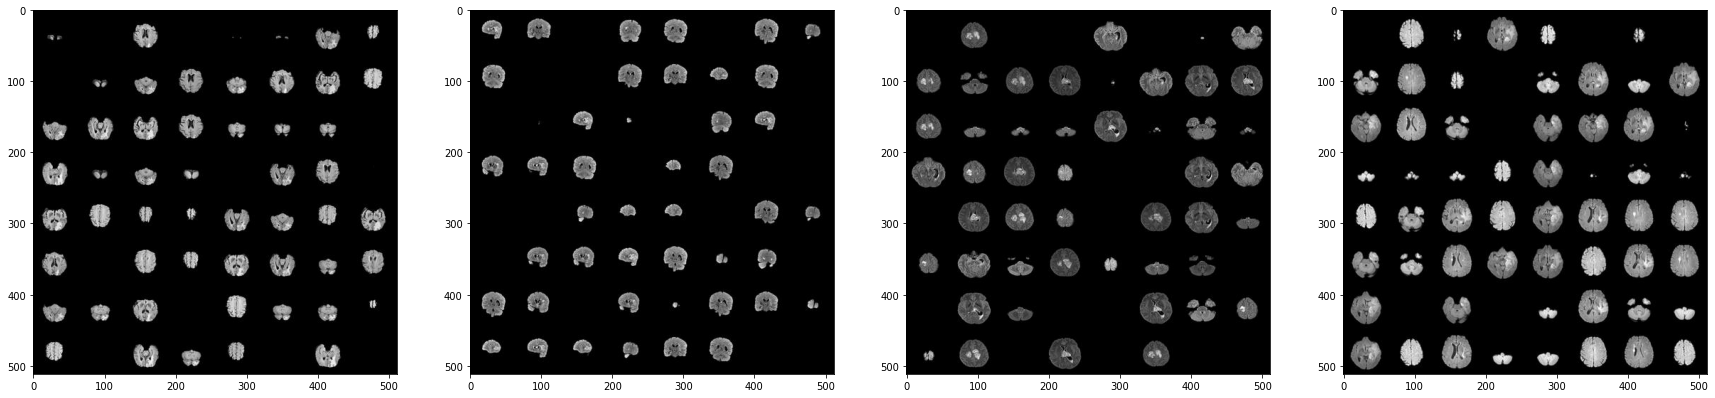

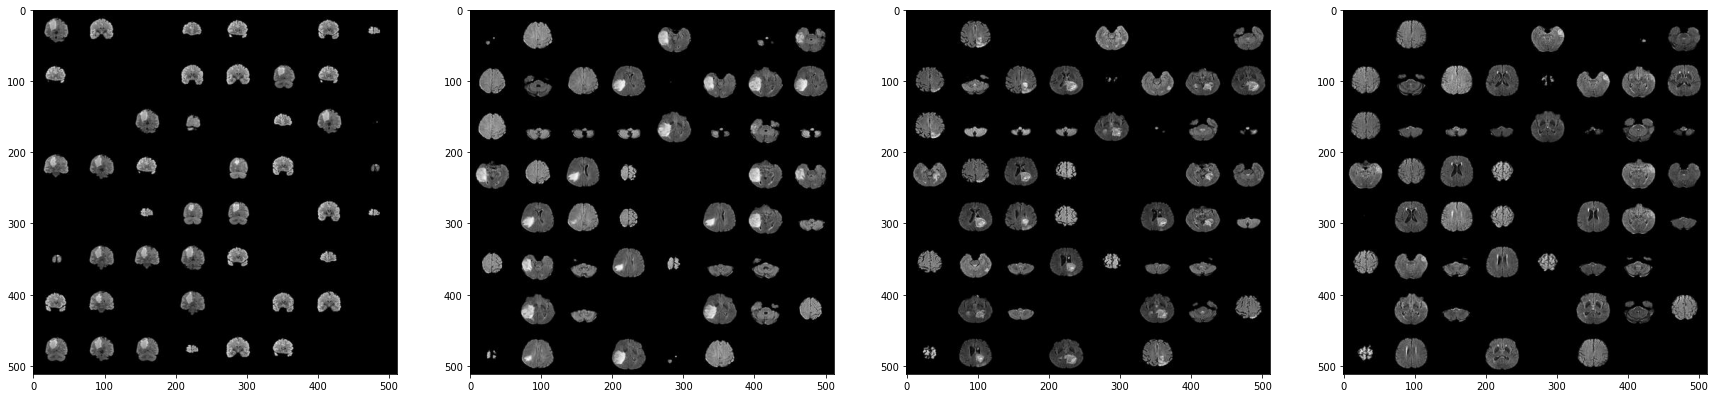

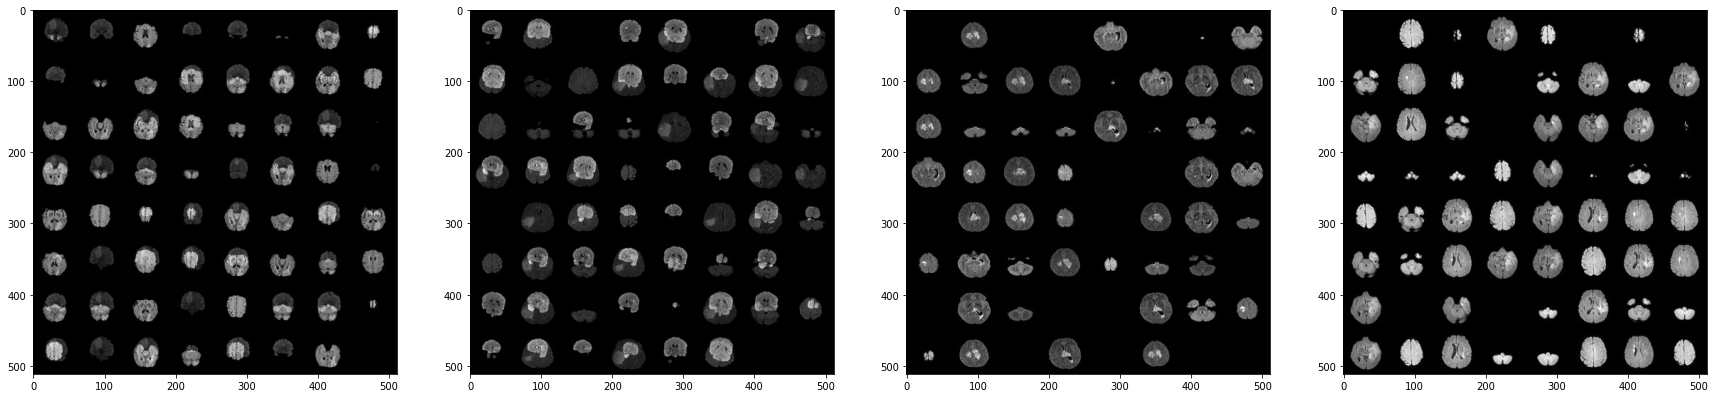

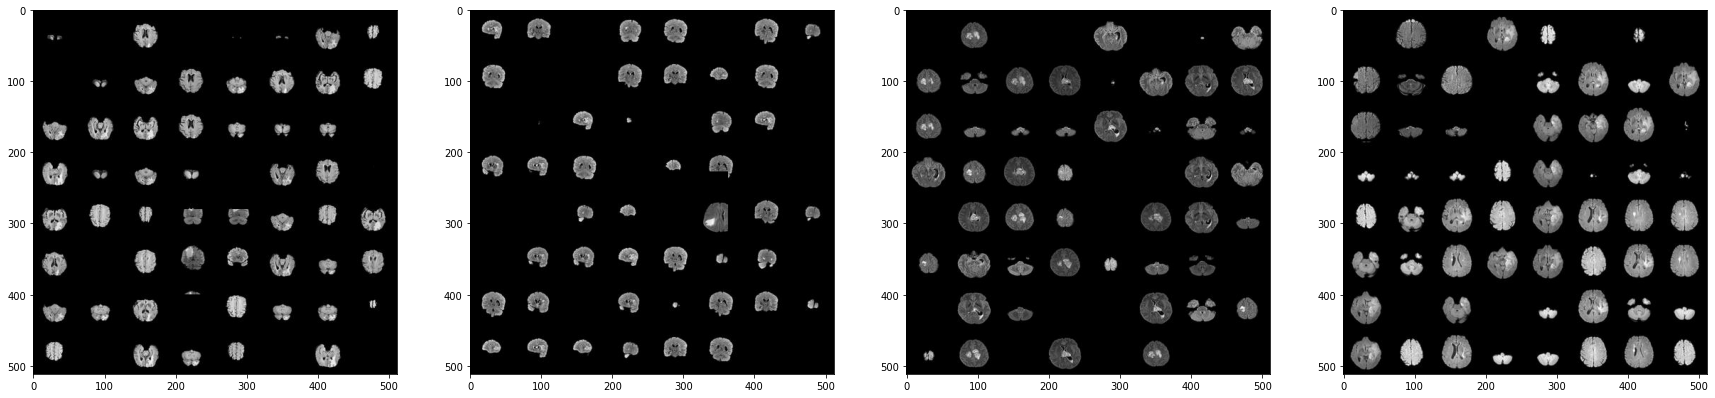

In [7]:
#debug (augment=None)
if 1:
  df_train_deb, _ = make_fold('train-0')
  train_dataset_deb = BTDataset(df_train_deb,df_meta_ext, augment=None)
  train_loader_deb = DataLoader(
            train_dataset_deb,
            sampler = RandomSampler(train_dataset_deb),
            batch_size = 4,
            drop_last   = True,
            num_workers = 2,
            pin_memory  = True,
            worker_init_fn=lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
            collate_fn  = null_collate,
        )
  it = iter(train_loader_deb)
  batch1=next(it)
  batch2=next(it)
  cutmix_batch = do_cutmix(batch1,batch2)
  mixup_batch = do_mixup(batch1,batch2)
  for key in ['image']:
    draw_batch(batch1[key])
    draw_batch(batch2[key])
    draw_batch(mixup_batch[key].cpu())
    draw_batch(cutmix_batch[key].cpu())

In [ ]:
def ohem_loss(logit,label,threshold=0.7):
  loss=F.binary_cross_entropy_with_logits(torch.reshape(logit,(-1,)), label,reduction='none')
  mask = (loss>threshold)
  return  (loss*mask).sum()/(mask.sum()+EPS)

def ohem_loss_v2(logit,label,rate=0.5):
  bs = logit.size(0)
  loss=F.binary_cross_entropy_with_logits(torch.reshape(logit,(-1,)), label,reduction='none')
  ohem,_ = loss.topk(k=int(rate * bs))
  
  return ohem.mean()

In [8]:
#augment=None
def run_train_mixup_cutmix():
    for fold in FOLDS_SET:
        out_dir = OUTPUT_DIR['NORM']+EXPERIMENT+'/fold%d'%fold
        
        initial_checkpoint=None
        if INITIAL_CHECKPOINTS[fold] is not None: 
          initial_checkpoint = OUTPUT_DIR['NORM']+EXPERIMENT+'/fold%d/checkpoint/'%fold+INITIAL_CHECKPOINTS[fold]

        best_map = 0.5
        start_lr   = 0.001#1
        min_lr =     0.000005
        batch_size = 32 #14 #22

        num_iteration = 20000
        iter_log    = 20
        iter_valid  = 20
        iter_save   = list(range(0, num_iteration+1, 200))
        a_iter_save = []

        ## setup  ----------------------------------------
        for f in ['checkpoint', 'train', 'valid', 'backup']: os.makedirs(out_dir + '/' + f, exist_ok=True)
        # backup_project_as_zip(PROJECT_PATH, out_dir +'/backup/code.train.%s.zip'%IDENTIFIER)

        log = Logger()
        log.open(out_dir + '/log.train.txt', mode='a')
        log.write('\n--- [START %s] %s\n\n' % (IDENTIFIER, '-' * 64))
        log.write('\t%s\n' % COMMON_STRING)
        log.write('\texpirement = %s\n' % EXPERIMENT)
        log.write('\tout_dir  = %s\n' % out_dir)
        log.write('\n')

        ## dataset ------------------------------------
        df_train, df_valid = make_fold('train-%d'%fold)
        train_dataset = BTDataset(df_train,df_meta_ext, augment=None)
        valid_dataset = BTDataset(df_valid,df_meta_ext, )

        train_loader1 = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            drop_last   = True,
            num_workers = 2,
            pin_memory  = True,
            worker_init_fn=lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
            collate_fn  = null_collate,
        )
        train_loader2 = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            drop_last   = True,
            num_workers = 2,
            pin_memory  = True,
            worker_init_fn=lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
            collate_fn  = null_collate,
        )
        valid_loader  = DataLoader(
            valid_dataset,
            sampler = SequentialSampler(valid_dataset),
            batch_size  = batch_size,
            drop_last   = False,
            num_workers = 2,
            pin_memory  = True,
            collate_fn  = null_collate,
        )

        log.write('train_dataset : \n%s\n'%(train_dataset))
        log.write('valid_dataset : \n%s\n'%(valid_dataset))
        log.write('\n')


        ## net ----------------------------------------
        log.write('** net setting **\n')

        if is_mixed_precision:
            scaler = amp.GradScaler()
            net = AmpNet().cuda()
        else:
            net = Net().cuda()


        if initial_checkpoint is not None:
            f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
            start_iteration = f['iteration']
            num_iteration = start_iteration + 10000
            start_epoch = f['epoch']
            state_dict  = f['state_dict']
            start_lr = f['lrate']
            best_map = f['map']
            net.load_state_dict(state_dict,strict=True)  #True
        else:
            start_iteration = 0
            start_epoch = 0


        log.write('net=%s\n'%(type(net)))
        log.write('\tinitial_checkpoint = %s\n' % initial_checkpoint)
        log.write('\n')

        # -----------------------------------------------
        if 0: ##freeze
            for p in net.block0.backbone.parameters(): p.requires_grad = False


        #optimizer = Lookahead(RAdam(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr), alpha=0.5, k=5)
        #optimizer = RAdam(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr)
        optimizer = MADGRAD( filter(lambda p: p.requires_grad, net.parameters()), lr=start_lr, momentum= 0.9, weight_decay= 0, eps= 1e-06)



        log.write('optimizer\n  %s\n'%(optimizer))
        log.write('\n')


        ## start training here! ##############################################
        log.write('** start training here! **\n')
        log.write('   fold = %d\n'%(fold))
        log.write('   is_mixed_precision = %s \n'%str(is_mixed_precision))
        log.write('   batch_size = %d\n'%(batch_size))
        log.write('   experiment = %s\n' % str(EXPERIMENT.split('/')[-2:]))
        log.write('                              |-----------VALID-------------------|-----TRAIN/BATCH -----|------TIME-----\n')
        log.write('rate   plateau   iter   epoch | loss    auc    rec    pre    acc  | loss0  loss1  loss2  |               \n')
        log.write('---------------------------------------------------------------------------------------------------------\n')
                  #0.00000     00   0.00*  0.00  | 0.000  0.000  0.000  0.000  0.000 | 0.000  0.000  0.000  |  0 hr 00 min

        def message(mode='print'):
            if mode==('print'):
                asterisk = ' '
                loss = batch_loss
            if mode==('log'):
                asterisk = '*' if iteration in a_iter_save else ' '
                loss = train_loss

            text = \
                '%0.5f  %-7d %5.3f%s %4.2f  | '%(rate, rate_plateau, iteration/10000, asterisk, epoch,) +\
                '%4.3f  %4.3f  %4.3f  %4.3f  %4.3f  | '%(*valid_loss,) +\
                '%4.3f  %4.3f  %4.3f  | '%(*loss,) +\
                '%s' % (time_to_str(timer() - start_timer,'min'))

            return text

        #----
        valid_loss = np.zeros(4,np.float32)
        train_loss = np.zeros(3,np.float32)
        batch_loss = np.zeros_like(train_loss)
        sum_train_loss = np.zeros_like(train_loss)
        sum_train = 0
        loss0 = torch.FloatTensor([0]).cuda().sum()
        loss1 = torch.FloatTensor([0]).cuda().sum()
        loss2 = torch.FloatTensor([0]).cuda().sum()


        start_timer = timer()
        iteration = start_iteration
        epoch = start_epoch
        rate = start_lr
        rate_plateau = 0

        while  iteration < num_iteration:
            if (rate<min_lr): break

            it_loader2 = iter(train_loader2)
            for t, batch1 in enumerate(train_loader1):
                

                if (iteration % iter_valid == 0):
                        valid_loss = do_valid(net, valid_loader) 
                        
                        if best_map < valid_loss[1]:
                          best_map = valid_loss[1]
                          a_iter_save.append(iteration)
                          rate_plateau=0
                          torch.save({
                            'state_dict': net.state_dict(),
                            'iteration': iteration,
                            'epoch': epoch,
                            'lrate': rate,
                            'map':best_map}, out_dir + '/checkpoint/best_model.pth')
                        else:
                          rate_plateau=rate_plateau+1

                if (iteration % iter_log == 0):
                    print('\r', end='', flush=True)
                    log.write(message(mode='log') + '\n')

                # learning rate schduler ------------
                rate = get_learning_rate(optimizer)

                if (rate_plateau>MAX_LR_PLATEAU):
                  rate_plateau=0
                  rate = rate*LR_FACTOR
                  best_model_pth = out_dir+'/checkpoint/best_model.pth'
                  f = torch.load(best_model_pth, map_location=lambda storage, loc: storage)
                  state_dict  = f['state_dict']
                  iteration = f['iteration']
                  epoch = f['epoch']

                  net.load_state_dict(state_dict,strict=True)
                  del optimizer
                  optimizer = MADGRAD( filter(lambda p: p.requires_grad, net.parameters()), lr=rate, momentum= 0.9, weight_decay= 0, eps= 1e-06)
                  break


                # mixup cutmix etc-----------
                with torch.no_grad():
                  prob = np.random.rand()
                  if prob<PROBS[0]:
                    batch2 = next(it_loader2)
                    mix_batch = do_mixup(batch1,batch2)
                  elif prob>=PROBS[0] and prob<PROBS[0]+PROBS[1]:
                    batch2 = next(it_loader2)
                    mix_batch = do_cutmix(batch1,batch2)
                  else:
                    mix_batch = {'image' :batch1['image'].cuda(),
                                 'mgmt':  batch1['mgmt'].cuda()}


                # one iteration update  -------------
                batch_size = len(batch1['index'])
                image = mix_batch['image']
                label =  mix_batch['mgmt']

                #----
                net.train()
                optimizer.zero_grad()

                if is_mixed_precision:
                    with amp.autocast():
                        logit = data_parallel(net, image)
                        loss0 = F.binary_cross_entropy_with_logits(torch.reshape(logit,(-1,)), label)
                        loss1 = loss0
                        loss2 = loss0 + loss1

                    
                    scaler.scale(loss0).backward()
                    scaler.unscale_(optimizer)
                    #torch.nn.utils.clip_grad_norm_(net.parameters(), 2)
                    scaler.step(optimizer)
                    scaler.update()


                else :
                    assert(False)
                    print('fp32')
                    logit = data_parallel(net, image)
                    loss0 = F.binary_cross_entropy(logit, label)
                    loss1 = loss0

                    (loss0).backward()
                    optimizer.step()


                # print statistics  --------
                epoch += 1 / len(train_loader1)
                iteration += 1

                batch_loss = np.array([loss0.item(), loss1.item(), loss2.item()])
                sum_train_loss += batch_loss
                sum_train += 1
                if iteration % 20 == 0:
                    train_loss = sum_train_loss / (sum_train + 1e-12)
                    sum_train_loss[...] = 0
                    sum_train = 0

                print('\r', end='', flush=True)
                print(message(mode='print'), end='', flush=True)


        log.write('\n')

In [9]:
run_train_mixup_cutmix()


--- [START 2021-08-18_13-52-02] ----------------------------------------------------------------

	@common.py:  
	pytorch
		seed = 1629294730
		torch.__version__              = 1.9.0+cu102
		torch.version.cuda             = 10.2
		torch.backends.cudnn.version() = 7605
		os['CUDA_VISIBLE_DEVICES']     = 0
		torch.cuda.device_count()      = 1
		torch.cuda.get_device_properties() = (name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


	expirement = SZ64_B0_TEST_64x8_CHAIN_NOAUG
	out_dir  = /content/drive/My Drive/kaggle/brain-tumor/output/SZ64_B0_TEST_64x8_CHAIN_NOAUG/fold0

train_dataset : 
	len = 465
	df  = (465, 9)

valid_dataset : 
	len = 117
	df  = (117, 9)


** net setting **


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


net=<class '__main__.AmpNet'>
	initial_checkpoint = None

optimizer
  MADGRAD (
Parameter Group 0
    eps: 1e-06
    lr: 0.001
    momentum: 0.9
    weight_decay: 0
)

** start training here! **
   fold = 0
   is_mixed_precision = True 
   batch_size = 32
   experiment = ['SZ64_B0_TEST_64x8_CHAIN_NOAUG']
                              |-----------VALID-------------------|-----TRAIN/BATCH -----|------TIME-----
rate   plateau   iter   epoch | loss    auc    rec    pre    acc  | loss0  loss1  loss2  |               
---------------------------------------------------------------------------------------------------------
0.00100  1       0.000  0.00  | 0.706  0.420  0.435  0.491  0.462  | 0.000  0.000  0.000  |  0 hr 00 min
0.00100  0       0.002* 1.43  | 0.687  0.561  0.839  0.559  0.564  | 0.688  0.688  1.376  |  0 hr 00 min
0.00100  0       0.004* 2.86  | 0.693  0.598  0.242  0.536  0.487  | 0.653  0.653  1.307  |  0 hr 01 min
0.00100  0       0.006* 4.29  | 0.689  0.622  0.500  0.608  0

In [10]:
def do_predict(net, valid_loader, tta=['flip','scale']): #flip

    valid_probability = []
    valid_num = 0

    start_timer = timer()
    for t, batch in enumerate(valid_loader):
        batch_size = len(batch['index'])
        image  = batch['image'].cuda()
        label =  batch['mgmt']

        #<todo> TTA
        net.eval()
        with torch.no_grad():
            probability = []
            logit = net(image)
            probability.append(torch.sigmoid(torch.reshape(logit,(-1,))))
            
            if 'flip' in tta:
                logit = net(torch.flip(image,dims=(3,)))
                probability.append(torch.sigmoid(torch.reshape(logit,(-1,))))

            if 'scale' in tta:
                # size=None, scale_factor=None, mode='nearest', align_corners=None, recompute_scale_factor=None):
                logit = net(F.interpolate(image, scale_factor=1.33, mode='bilinear', align_corners=False))
                probability.append(torch.sigmoid(torch.reshape(logit,(-1,))))

            #--------------
            probability = torch.stack(probability,0).mean(0)
            #print("\nprob: ",probability.shape,probability)

        valid_num += batch_size
        valid_probability.append(probability.data.cpu().numpy())
        print('\r %8d / %d  %s' % (valid_num, len(valid_loader.dataset), time_to_str(timer() - start_timer, 'sec')),
              end='', flush=True)

    assert(valid_num == len(valid_loader.dataset))
    print('')

    probability = np.concatenate(valid_probability)
    return probability

In [11]:
def probability_to_df_submit(df_valid, probability):
  df_submit = pd.DataFrame()
  df_submit.loc[:,'BraTS21ID']=df_valid.id_dir
  df_submit['MGMT_value']=probability

  return df_submit

In [12]:
#no tta
def eval_public_test():
    for fold in FOLDS_SET:
        out_dir = OUTPUT_DIR['NORM']+EXPERIMENT+'/fold%d'%fold
        initial_checkpoint = out_dir + '/checkpoint/'+INITIAL_CHECKPOINTS[fold] # None #
        mode='public_test'
        submit_dir = out_dir + '/valid/%s'%(mode)
        os.makedirs(submit_dir, exist_ok=True)
        log = Logger()
        log.open(out_dir + '/log.submit.txt', mode='a')
        log.write('\n--- [START %s] %s\n\n' % (IDENTIFIER, '-' * 64))
        log.write('\t%s\n' % COMMON_STRING)
        log.write('\n')
        df_valid = make_fold('test')
        valid_dataset = BTDataset(df_valid,df_meta_ext)
        valid_loader  = DataLoader(
                valid_dataset,
                sampler = SequentialSampler(valid_dataset),
                batch_size  = 16,#128, #
                drop_last   = False,
                num_workers = 2,
                pin_memory  = True,
                collate_fn  = null_collate,
            )
        log.write('mode : %s\n'%(mode))
        log.write('valid_dataset : \n%s\n'%(valid_dataset))
        ## net ----------------------------------------
        if 1:
                net = Net().cuda()
                net.load_state_dict(torch.load(initial_checkpoint)['state_dict'], strict=True)

                #---
                start_timer = timer()
                probability = do_predict(net, valid_loader, tta=[])
                log.write('time %s \n' % time_to_str(timer() - start_timer, 'min'))
                log.write('probability %s \n' % str(probability.shape))

                np.save(submit_dir + '/probability.npy',probability)
                df_valid.to_csv(submit_dir + '/df_valid.csv', index=False)

        else:
                probability = np.load(submit_dir + '/probability.npy')

        #----
        df_submit = probability_to_df_submit(df_valid,probability)
        df_submit.to_csv(submit_dir + '/submit.csv', index=False)

        log.write('submit_dir : %s\n' % (submit_dir))
        log.write('initial_checkpoint : %s\n' % (initial_checkpoint))
        log.write('df_submit : %s\n' % str(df_submit.shape))
        log.write('%s\n' % str(df_submit))
        log.write('\n')

In [13]:
INITIAL_CHECKPOINTS=['best_model.pth',None,None,None,None]

In [14]:
eval_public_test()


--- [START 2021-08-18_13-52-02] ----------------------------------------------------------------

	@common.py:  
	pytorch
		seed = 1629294730
		torch.__version__              = 1.9.0+cu102
		torch.version.cuda             = 10.2
		torch.backends.cudnn.version() = 7605
		os['CUDA_VISIBLE_DEVICES']     = 0
		torch.cuda.device_count()      = 1
		torch.cuda.get_device_properties() = (name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)



mode : public_test
valid_dataset : 
	len = 87
	df  = (87, 9)

       87 / 87   0 min 04 sec
time  0 hr 00 min 
probability (87,) 
submit_dir : /content/drive/My Drive/kaggle/brain-tumor/output/SZ64_B0_TEST_64x8_CHAIN_NOAUG/fold0/valid/public_test
initial_checkpoint : /content/drive/My Drive/kaggle/brain-tumor/output/SZ64_B0_TEST_64x8_CHAIN_NOAUG/fold0/checkpoint/best_model.pth
df_submit : (87, 2)
   BraTS21ID  MGMT_value
0      00001    0.015100
1      00013    0.014673
2      00015    0.210420
3      00027    0.